In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install gpytorch

tcmalloc: large alloc 1073750016 bytes == 0x57d7a000 @  0x7fe7b4da02a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
 # All your import statements here
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, cho_solve, cho_factor
import tensorflow as tf
import torch
import gpytorch
import math
torch.set_default_tensor_type('torch.DoubleTensor')
import torch.optim as optim

from matplotlib import cm
from gpytorch.kernels import Kernel
from matplotlib import gridspec
import itertools
import sys
import time
is_colab = 'google.colab' in sys.modules
print(is_colab)
print(sys.version)

True
3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [0]:
# define the matplotlib function to be used
# def plot(img):
#   plt.figure()
#   plt.contourf(img, cmap=plt.cm.Blues)
#   plt.colorbar()
#   plt.show()
#   return
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
SIZE = (-25, 25)
def plot(Z):
  x1 = np.arange(SIZE[0], SIZE[1], 1)
  x2 = np.arange(SIZE[0], SIZE[1], 1)
  X, Y = np.meshgrid(x1, x2)
    
  fig = plt.figure()
  ax = fig.gca(projection='3d')

  # Plot the surface.
  surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

  up_lim = np.max(Z)
  down_lim = np.min(Z)
  # Customize the z axis.
  ax.set_zlim(down_lim+0.3*down_lim, up_lim+0.3*up_lim)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  plt.show()

In [0]:
# generate data either complete or with missing observations
NOISE = 1e-2
def generate_data(missing=False, style='parabola', miss_variance=1e6, noise=True):
  x1 = np.arange(SIZE[0], SIZE[1], 1)
  x2 = np.arange(SIZE[0], SIZE[1], 1)
  miss = None
  if style=='plane':
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = X + Y * 1.0
  if style=='parabola':
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = X**2/4 + Y**2/8
  if style=='double':
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = 1.0*(X**3/16 + Y**3/64)
  if style=='sine':
    # create observations on the grid and add some noise. Right now using sine
    X, Y = np.meshgrid(x1, x2)
    size = Y.shape[0] * Y.shape[1]
    z = np.sin(X) + Y
  if noise:
    z += np.random.normal(0, NOISE, z.shape)
  if missing:
    points = np.reshape(np.random.uniform(-1, 1, 50 * 50), (50, 50))
    miss = points > 0.90
    points = np.sum(miss)
    z[miss] = 0.0
    plot(z)
    z[miss] = np.random.normal(0, miss_variance, points)
    print(np.sum(miss)/ size *100)
  else:
    miss = np.array(np.zeros(z.shape), dtype='bool')
    z += np.random.normal(0, 1e-2, z.shape)
    plot(z)
  return z, miss

In [0]:
# builds the covariance kernel for convolution
def conv_kernel(N, sigma_f=5, l=1e-3):
  K_prime = np.zeros((2*N-1, 2*N-1))
  count_i = 0
  for i in np.arange(-1*(N-1), N, 1):
    count_j = 0
    for j in np.arange(-1*(N-1), N, 1):
      K_prime[count_i, count_j] = sigma_f**2 * np.exp(-1 * (i**2+j**2)/(2*l**2))
      count_j += 1
    count_i += 1
  return K_prime

In [0]:
# builds the naive GP covariance kernel
def squared_exponential_kernel(shape, l=1e-3, sigma_f=5):
  x = np.arange(0, shape, 1)
  y = np.arange(0, shape, 1)
  iters = list(itertools.product(x, y))
  K = np.zeros((shape*shape, shape*shape))
  count = 0
  for i, list_i in enumerate(iters):
    x_i = np.array(list_i)
    for j, list_j in enumerate(iters):
      x_j = np.array(list_j)
      diff = x_i - x_j
      # print(i, j, diff, np.dot(diff, diff), np.exp(-1 * diff.T.dot(diff)/(2*l**2)))
      K[i, j] = sigma_f**2 * np.exp(-1 * diff.T.dot(diff)/(2*l**2))
  return K

In [0]:
class TorchConvLayer(torch.nn.Module):
  def __init__(self, N, kernel, y, gpu=False):
    super(TorchConvLayer, self).__init__()
    self.y_flat = torch.from_numpy(np.ndarray.flatten(y)).double()
    input_vector = np.array(kernel)
    self.y = y
    # tensorflow
    input_vector = np.expand_dims(input_vector, axis=0)     # for the number of examples which is one here
    input_vector = np.expand_dims(input_vector, axis=1)     # for the number of channels which is one here
    self.input_vector = torch.from_numpy(np.array(input_vector)).double()
    print(input_vector.shape)
    
    # tensorflow
    self.conv_layer = torch.nn.Conv2d(1, 1, (N, N), bias=False, dilation=1, padding=0)
    # self.conv_layer.weight = torch.nn.Parameter(torch.from_numpy(np.reshape(np.random.normal(0,1,(N, N)), (1,1,N,N))).double())
    self.N = N
    if gpu:
      self.input_vector = self.input_vector.cuda()
      self.y_flat = self.y_flat.cuda()
    self.loss_plot = []
    self.count = 0
    
  def forward(self): 
    return self.conv_layer(self.input_vector)
  
  def loss(self):
    y_prime = self.forward()
    # v_prime (1, 1, 50, 50)
    v_prime = self.conv_layer.weight
    # v 2500
    v = v_prime.view(self.N * self.N)
    v = torch.flip(v, dims=(0, ))
    # 2500
    y_prime = y_prime.view(self.N * self.N)
  
    temp = self.y_flat - y_prime
    first = 0.5 * (1/NOISE) * torch.dot(temp, temp)
    #first = 0.5 * torch.dot(temp, temp)
    second = 0.5 * torch.dot(v, y_prime)
    loss = (first + second)
    # print(self.y_flat.size(), y_prime.size(), v.size())
    
    # housekeeping
    self.loss_plot.append(loss)
#     if self.count%100 == 0:
#       self.print_vec(y_prime.detach().numpy(), loss.detach().numpy())      
    return loss
  
  def fit(self):
    self.count = 0
    # optimization step
    adam = optim.Adam(self.parameters(), lr=0.1)
    loss_plot = []
    for i in range(400):
      adam.zero_grad()
      loss = self.loss()
      loss.backward()
      adam.step()
      self.count += 1
    return   

  def print_vec(self, y_prime, loss):
    N = self.N
    # plot new image
    img = np.reshape(y_prime, (N, N))
    loss = np.sum(((self.y - img))**2) 
    print('loss: ', loss)
    plot(img)
    print(np.allclose(self.y, img, atol=1e-15))
    return loss

In [0]:
def generate_noise(N):
  D = np.zeros((N*N, N*N))
  for i in np.arange(0, N*N, 1):
    for j in np.arange(0, N*N, 1):
      if i == j:
          D[i, j] += NOISE
  return D

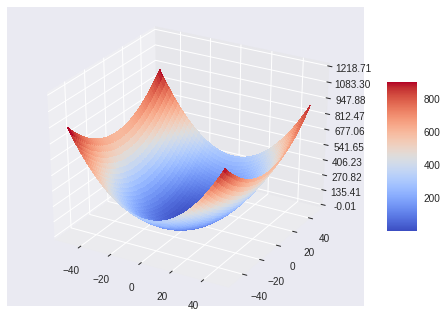

(1, 1, 199, 199)
time: 10.030410528182983


TypeError: ignored

In [0]:
y, _ = generate_data(style='parabola', noise=True, missing=False)
K_prime = conv_kernel(y.shape[0])
D = generate_noise(y.shape[0])
#D = np.zeros((y.shape[0]*y.shape[0], y.shape[0]*y.shape[0]))
conv_layer = TorchConvLayer(y.shape[0], K_prime, y, gpu=torch.cuda.is_available())
if torch.cuda.is_available():
  conv_layer.cuda()
start = time.time()
conv_layer.fit()
end = time.time()
print('time:', (end-start))
y_prime_conv = conv_layer.forward().detach().numpy()
plt.plot(conv_layer.loss_plot)
v = np.ndarray.flatten(y_prime_conv)

# cholesky
# K = squared_exponential_kernel(y.shape[0])
# N = y.shape[0]
# K_inv = np.linalg.inv(K+D)
# alpha = np.dot(K_inv, np.ndarray.flatten(y))
# # alpha = np.linalg.solve((K+D), v)
# predictive = np.dot(K, alpha)

# print(np.sum((predictive - v)**2))
# print(np.allclose(predictive, v, atol=1e-15))

In [0]:
#!/usr/bin/env python3

from gpytorch.kernels import Kernel
from gpytorch.utils.deprecation import _deprecate_kwarg
from torch.nn.functional import softplus


class CustomRBFKernel(Kernel):
    r"""
    Computes a covariance matrix based on the RBF (squared exponential) kernel
    between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

    .. math::

       \begin{equation*}
          k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2}
          (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-1} (\mathbf{x_1} - \mathbf{x_2}) \right)
       \end{equation*}

    where :math:`\Theta` is a :attr:`lengthscale` parameter.
    See :class:`gpytorch.kernels.Kernel` for descriptions of the lengthscale options.

    .. note::

        This kernel does not have an `outputscale` parameter. To add a scaling parameter,
        decorate this kernel with a :class:`gpytorch.kernels.ScaleKernel`.

    Args:
        :attr:`ard_num_dims` (int, optional):
            Set this if you want a separate lengthscale for each
            input dimension. It should be `d` if :attr:`x1` is a `n x d` matrix. Default: `None`
        :attr:`batch_size` (int, optional):
            Set this if you want a separate lengthscale for each
            batch of input data. It should be `b` if :attr:`x1` is a `b x n x d` tensor. Default: `1`.
        :attr:`active_dims` (tuple of ints, optional):
            Set this if you want to compute the covariance of only a few input dimensions. The ints
            corresponds to the indices of the dimensions. Default: `None`.
        :attr:`lengthscale_prior` (Prior, optional):
            Set this if you want to apply a prior to the lengthscale parameter.  Default: `None`.
        :attr:`param_transform` (function, optional):
            Set this if you want to use something other than softplus to ensure positiveness of parameters.
        :attr:`inv_param_transform` (function, optional):
            Set this to allow setting parameters directly in transformed space and sampling from priors.
            Automatically inferred for common transformations such as torch.exp or torch.nn.functional.softplus.
        :attr:`eps` (float):
            The minimum value that the lengthscale can take (prevents divide by zero errors). Default: `1e-6`.

    Attributes:
        :attr:`lengthscale` (Tensor):
            The lengthscale parameter. Size/shape of parameter depends on the
            :attr:`ard_num_dims` and :attr:`batch_size` arguments.

    Example:
        >>> x = torch.randn(10, 5)
        >>> # Non-batch: Simple option
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        >>> # Non-batch: ARD (different lengthscale for each input dimension)
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=5))
        >>> covar = covar_module(x)  # Output: LazyTensor of size (10 x 10)
        >>>
        >>> batch_x = torch.randn(2, 10, 5)
        >>> # Batch: Simple option
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        >>> # Batch: different lengthscale for each batch
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_size=2))
        >>> covar = covar_module(x)  # Output: LazyTensor of size (2 x 10 x 10)
    """

    def __init__(
        self,
        ard_num_dims=None,
        batch_size=1,
        active_dims=None,
        lengthscale_prior=None,
        param_transform=softplus,
        inv_param_transform=None,
        eps=1e-6,
        **kwargs
    ):
        _deprecate_kwarg(kwargs, "log_lengthscale_prior", "lengthscale_prior", lengthscale_prior)
        super(CustomRBFKernel, self).__init__(
            has_lengthscale=True,
            ard_num_dims=ard_num_dims,
            batch_size=batch_size,
            active_dims=active_dims,
            lengthscale_prior=lengthscale_prior,
            param_transform=param_transform,
            inv_param_transform=inv_param_transform,
            eps=eps,
        )

    def forward(self, x1, x2, **params):
        mask = x2 == -25
        x2[mask] = x2[mask] + NOISE
        print(mask, x2)
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        x1_, x2_ = self._create_input_grid(x1_, x2_, **params)
        l = 1e-3
        sigma_f = 5
        diff = (x1_ - x2_).norm(2, dim=-1)
        diff = diff/(2*l**2)
        to_return = sigma_f**2 * diff.pow(2).div_(-2).exp_()
        return to_return


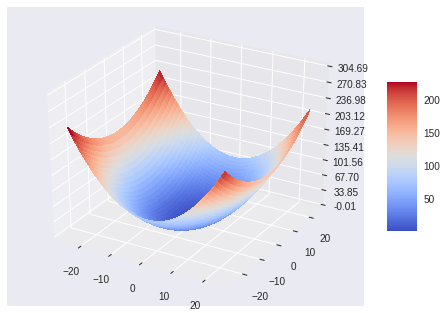

In [0]:
x = np.arange(SIZE[0], SIZE[1])
y = np.arange(SIZE[0], SIZE[1])
grid = np.column_stack((x, y))
grid = torch.from_numpy(grid).double()
train_x = gpytorch.utils.grid.create_data_from_grid(grid)
train_y, _ = generate_data(missing=False, style='parabola', noise=True)
train_y = torch.from_numpy(np.ndarray.flatten(train_y)).double()

class GridGPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, grid, train_x, train_y, likelihood):
        super(GridGPRegressionModel, self).__init__(train_x, train_y, likelihood)
        num_dims = train_x.size(-1)
        n = train_x.size(0)
        variance = np.ones(n) * NOISE
        variance = torch.from_numpy(variance)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.GridKernel(CustomRBFKernel()+gpytorch.kernels.WhiteNoiseKernel(variance), grid=grid)
        self.covar_module = gpytorch.kernels.GridKernel(CustomRBFKernel(), grid=grid)
        #self.covar_module = gpytorch.kernels.GridKernel(gpytorch.kernels.RBFKernel(), grid=grid)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GridGPRegressionModel(grid, train_x, train_y, likelihood)
if torch.cuda.is_available():
  model.cuda()
        

In [0]:
start = time.time()
model.eval()
dist = model(train_x.cuda())
if torch.cuda.is_available():
  mean = dist.mean.cuda()
else:
  mean = dist.mean.detach().numpy()
end = time.time()
print('time:', (end-start))
covariance = dist.covariance_matrix.cpu().detach().numpy()
print(mean.shape)
print(covariance.shape)
print(mean)
print(covariance)

/usr/local/lib/python3.6/dist-packages/gpytorch/models/exact_gp.py:86: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]]], device='cuda:0', dtype=torch.uint8) tensor([[[-24.9900, -24.9900],
         [-24.0000, -24.0000],
         [-23.0000, -23.0000],
         [-22.0000,

In [0]:
K = squared_exponential_kernel(y.shape[0])

RuntimeError: ignored

In [0]:
mean_ = np.reshape(mean, (50, 50))
K_D = K + np.identity(K.shape[0]) * NOISE
K_inv = np.linalg.inv(K_D)
alpha = np.dot(K_inv, np.ndarray.flatten(train_y.cpu().detach().numpy()))
# alpha = np.linalg.solve((K+D), v)
predictive = np.dot(K, alpha)
predictive = np.reshape(predictive, (50, 50))

print(np.sum((predictive - mean_)**2))
print(np.allclose(predictive, mean_, atol=1e-15))

11.072901760893433
False
